## Importing libraries and data

This notebook utilizes the Telecom churn data on Kaggle to demonstrate how to build a Logistic Regression and Neural Network from scratch. To view the notebook with more data exploration and the implementation of Random Forest, XGBoost and TensorFlow, please refer to the following notebooks here ---> 
- https://www.kaggle.com/code/arsalanpardesi/churn-prediction-telecom-customers

- https://www.kaggle.com/code/arsalanpardesi/churn-prediction-telecom-customers-incl-tf

In [1]:
#----main libraries----
import numpy as np
import pandas as pd
import copy
import scipy


#----plotting libraries----
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# Load data - we will load the data and perform the same cleaning steps as before

tel_cus_df = pd.read_csv("./data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Data cleansing and preparation - refer to the old notebook for explanation

#Total charges is type object. Check for empty values and covert to a numeric data type
tel_cus_df['TotalCharges'] = tel_cus_df['TotalCharges'].replace(' ', np.nan, regex=True)
tel_cus_df['TotalCharges'] = pd.to_numeric(tel_cus_df['TotalCharges'])
tel_cus_df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [4]:
# create number of months for contract type to fill null totalcharges

tel_cus_df['ContractMonths'] = np.where(tel_cus_df['Contract']=="Month-to-month", 1, 0) + np.where(tel_cus_df['Contract']=="One year", 12, 0) + np.where(tel_cus_df['Contract']=="Two year", 24, 0)
tel_cus_df['ContractMonths'] = pd.to_numeric(tel_cus_df['ContractMonths'])
tel_cus_df.loc[tel_cus_df['TotalCharges'].isnull(), ['Contract','ContractMonths','MonthlyCharges','TotalCharges']]

,Contract,ContractMonths,MonthlyCharges,TotalCharges
488,Two year,24,52.55,NaN
753,Two year,24,20.25,NaN
936,Two year,24,80.85,NaN
1082,Two year,24,25.75,NaN
1340,Two year,24,56.05,NaN
3331,Two year,24,19.85,NaN
3826,Two year,24,25.35,NaN
4380,Two year,24,20.00,NaN
5218,One year,12,19.70,NaN
6670,Two year,24,73.35,NaN


In [5]:
tel_cus_df['cal_TotalCharges'] = tel_cus_df['ContractMonths'] * tel_cus_df['MonthlyCharges']
tel_cus_df['TotalCharges'] = np.where(tel_cus_df['TotalCharges'].isnull(), tel_cus_df['cal_TotalCharges'], tel_cus_df['TotalCharges'])
tel_cus_df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
ContractMonths      0
cal_TotalCharges    0
dtype: int64

In [6]:
tel_cus_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ContractMonths,cal_TotalCharges
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1,29.85
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.50,No,12,683.40
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,53.85
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,12,507.60
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,70.70


In [7]:
# Drop CustomerID and other columns not required

tel_cus_df.drop(['customerID','ContractMonths','cal_TotalCharges'], axis=1, inplace=True)
tel_cus_df.columns.values

array(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

# Logistic regression
## Model configuration

In [8]:
# importing sklearn for processing data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [9]:
le = LabelEncoder()
tel_cus_df['Churn'] = le.fit_transform(tel_cus_df['Churn'])

In [10]:
# converting categorical items into dummy variables

df_dummy = pd.get_dummies(tel_cus_df)
df_dummy.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,True,False,False,True,True,...,False,True,False,False,False,True,False,False,True,False
1,0,34,56.95,1889.50,0,False,True,True,False,True,...,False,False,True,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,False,True,True,False,True,...,False,True,False,False,False,True,False,False,False,True
3,0,45,42.30,1840.75,0,False,True,True,False,True,...,False,False,True,False,True,False,True,False,False,False
4,0,2,70.70,151.65,1,True,False,True,False,True,...,False,True,False,False,False,True,False,False,True,False


In [11]:
X = df_dummy.drop("Churn", axis = 1)
y = df_dummy['Churn']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 100, test_size = 0.2)
print(y_train.value_counts())

Churn
0    4149
1    1485
Name: count, dtype: int64


In [13]:
# Using MinMaxScaler to regularize input

scale = MinMaxScaler()
col = X_train.columns

X_train[col] = scale.fit_transform(X_train[col])
X_test[col] = scale.transform(X_test[col])

In [14]:
#lets check the shape of our training and test set

m_train = X_train.shape[0]
m_test = X_test.shape[0]
num_x = X_train.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of test examples: m_test = " + str(m_test))
print ("Number of features: num_x = " + str(num_x))
print ("X_train shape: " + str(X_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("y_test shape: " + str(y_test.shape))

Number of training examples: m_train = 5634
Number of test examples: m_test = 1409
Number of features: num_x = 45
X_train shape: (5634, 45)
y_train shape: (5634,)
X_test shape: (1409, 45)
y_test shape: (1409,)


In [15]:
#Change shapes to have X to (nx, m) and y to (1,m) and dataframes to numpy arrays

train_set_x = X_train.to_numpy().T
test_set_x = X_test.to_numpy().T
train_set_y = y_train.values.reshape(y_train.shape[0], 1).T
test_set_y = y_test.values.reshape(y_test.shape[0],1).T


print ("train_set_x shape: " + str(type(train_set_x)) + " " + str(train_set_x.shape))
print ("train_set_y shape: " + str(type(train_set_y)) + " " + str(train_set_y.shape))
print ("test_set_x shape: " + str(type(test_set_x)) + " " + str(test_set_x.shape))
print ("test_set_y shape: " + str(type(test_set_y)) + " " + str(test_set_y.shape))

train_set_x shape: <class 'numpy.ndarray'> (45, 5634)
train_set_y shape: <class 'numpy.ndarray'> (1, 5634)
test_set_x shape: <class 'numpy.ndarray'> (45, 1409)
test_set_y shape: <class 'numpy.ndarray'> (1, 1409)


**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{4}$$

The sigmoid is calculated as follows:
$$sigmoid(z) = \frac{1}{1 + e^{-z}}\tag{5}$$

For backpropagation we will be using:

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{6}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{7}$$

### Creating functions to support the logistic regression model

In [16]:
# Defining a function to calculate sigmoid

def sigmoid(z):
    
    s = 1. / (1+np.exp(-z))
    
    return s

In [17]:
# Initializing parameters w and b

def initialize_with_zeros(dim):
    
    w = np.zeros((dim,1))
    b = 0.0
    
    return w, b

In [18]:
# Define forward propagation and backward propagation

def propagate(w, b, X, Y):
    
    m = X.shape[1]
    
    #forward propagation
    A = sigmoid(np.dot(w.T, X) + b)
    cost = (-1./m) * np.sum((Y * np.log(A)) + ((1-Y)* (np.log(1-A))))
    
    #backward propagation
    
    dz = A - Y
    dw = (1./m) * np.dot(X, dz.T)
    db = (1./m) * np.sum(dz)
    
    cost = np.squeeze(np.array(cost))
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost   

In [19]:
# optimization function - Learn w and b by minimizing the cost function J

def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - (learning_rate * dw)
        b = b - (learning_rate * db)
        
        # print cost for every 100 iteration
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs   
    

In [20]:
# predicting the values

def predict(w, b, X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)
     
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        
        if A[0,i] > 0.5:
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
            
    return Y_prediction

In [21]:
del X_train, X_test, y_train, y_test

In [22]:
# Defining the model

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.005, print_cost=False):
    
    mX_train = X_train.shape[0]
    w, b = initialize_with_zeros(mX_train)
    
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations=num_iterations, learning_rate=learning_rate, print_cost=print_cost)
    
    w = params["w"]
    b = params["b"]
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    #print costs
    if print_cost:
        print("training accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    accuracy = 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100
    true_pos = np.multiply(Y_prediction_test, Y_test) 
    recall = np.squeeze(np.sum(true_pos, axis = 1) / np.sum(Y_test, axis = 1) * 100)[()]
    precision = np.squeeze(np.sum(true_pos, axis = 1) / np.sum(Y_prediction_test) *100)[()]
    
    results_dic = {"costs": costs,
                   "Y_prediction_test": Y_prediction_test,
                   "Y_prediction_train": Y_prediction_train,
                   "w": w,
                   "b": b,
                   "learning_rate": learning_rate,
                   "num_iterations": num_iterations,
                   "accuracy": accuracy,
                   "recall": recall,
                   "precision": precision}
    
    return results_dic 

In [23]:
LR = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.576174
Cost after iteration 200: 0.538158
Cost after iteration 300: 0.516368
Cost after iteration 400: 0.500736
Cost after iteration 500: 0.488704
Cost after iteration 600: 0.479173
Cost after iteration 700: 0.471486
Cost after iteration 800: 0.465195
Cost after iteration 900: 0.459982
Cost after iteration 1000: 0.455614
Cost after iteration 1100: 0.451917
Cost after iteration 1200: 0.448758
Cost after iteration 1300: 0.446039
Cost after iteration 1400: 0.443679
Cost after iteration 1500: 0.441618
Cost after iteration 1600: 0.439806
Cost after iteration 1700: 0.438204
Cost after iteration 1800: 0.436779
Cost after iteration 1900: 0.435506
training accuracy: 79.69471068512603 %
test accuracy: 78.14052519517388 %


<function matplotlib.pyplot.show(close=None, block=None)>

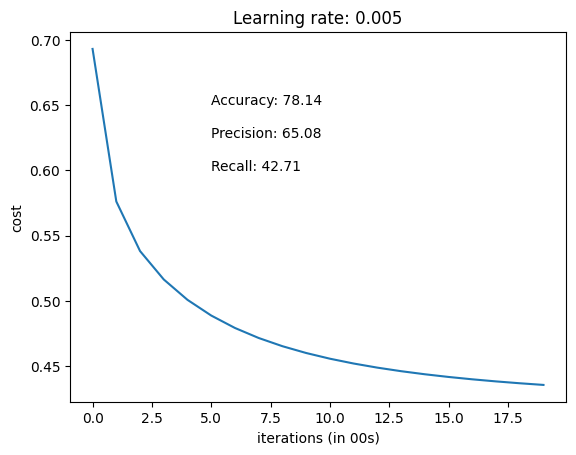

In [24]:
costs = np.squeeze(LR['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (in 00s)')
plt.title("Learning rate: " + str(LR["learning_rate"]))
plt.text(5, 0.65, "Accuracy: " + str(np.around(LR["accuracy"],2)) , fontsize = 10)
plt.text(5, 0.625, "Precision: " + str(np.around(LR["precision"],2)), fontsize = 10)
plt.text(5, 0.60, "Recall: " + str(np.around(LR["recall"],2)), fontsize = 10)
plt.show

# Neural network

## Model configuration

In [25]:
#setting up random seed to get the same answer while working

np.random.seed(100)

"""
Similar to logistic regression, we will follow the steps below:
1) Defining the sigmoid function and ReLU
2) Initializing our parameters
3) Defining Forward propagation
4) Calculate cost
5) Defining Backward propagation
6) Defining Optimization function
7) Bringing it all together and training the model

"""
print("Defining NN")


Defining NN


In [26]:
# sigmoid function

def sigmoid2(Z):
    A = 1. / (1+np.exp(-Z))
    cache = Z
    
    return A, cache

In [27]:
#ReLU function - it is essentially a linear function that returns Z, if positive, otherwise zero

def relu(Z):
    A = np.maximum(0, Z)
    assert(A.shape == Z.shape)
    cache = Z
    
    return A, cache

In [28]:
#backward propagation for sigmoid

def sigmoid2_backward(dA, cache):
    Z = cache
    
    s = 1. / (1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [29]:
#backward propagation for ReLU

def relu_backward(dA, cache):
    Z = cache
    
    dZ = np.array(dA, copy=True)
    
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [45]:
# Initialize parameters

def initialize_parameters_deep(layers_dims):
    
    np.random.seed(100)
    parameters = {}
    L = len(layers_dims)
    
    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2/layers_dims[l-1])
        parameters["b" + str(l)] = np.zeros((layers_dims[l],1))
        
        assert(parameters["W" + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
        assert(parameters["b" + str(l)].shape == (layers_dims[l], 1))
    
    return parameters

In [31]:
# linear forward propagation

def linear_forward(A, W, b):
    
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    
    return Z, cache

In [32]:
# linear forward activation

def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid2(Z)
        
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [33]:
# Applying forward propagation over L layers

def L_model_forward(X, parameters):
    
    caches = []
    A = X
    L = len(parameters) // 2
    
    for l in range(1, L):
        A_prev = A
        
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activation = "relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    return AL, caches        

In [34]:
# defining cost - cross-entropy cost

def compute_cost(AL, Y):
    m = Y.shape[1]
    
    cost = (-1/ m) * np.sum((Y * np.log(AL)) + ((1-Y)*(np.log(1-AL))))
    
    cost = np.squeeze(cost)
    
    return cost

In [35]:
# linear backward propagation

def linear_backward(dZ, cache):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = (1./m) * np.dot(dZ, A_prev.T)
    db = (1./m) * np.sum(dZ, axis=1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [36]:
# linear backward activation

def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    elif activation == "sigmoid":
        
        dZ = sigmoid2_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [37]:
# applying backward propagation over L layers

def L_model_backward(AL, Y, caches):
    
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    #for L-th layer
    
    dAL = - (np.divide(Y, AL) - np.divide(1-Y, 1-AL))
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    #for all prior layers
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp
        
    return grads   
    

In [38]:
def update_parameters(params, grads, learning_rate):
    
    parameters = params.copy()
    L = len(parameters) // 2
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - (np.multiply(learning_rate, grads["dW" + str(l+1)]))
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - (np.multiply(learning_rate, grads["db" + str(l+1)]))
    
    return parameters

In [57]:
#setting layers for the NN

layers_dims = [45, 16, 8, 4, 1]

In [59]:
# defining the model

def L_layer_model(X, Y, layers_dim, learning_rate = 0.0075, num_iterations = 3000, print_cost = False):
    
    np.random.seed(100)
    costs = []
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):
        
        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL, Y)
        
        grads = L_model_backward(AL, Y, caches)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 100 == 0 or i == num_iterations -1:
            print("Cost after iteration {} : {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs, learning_rate

In [75]:
# predicting results

def predict(X, y, parameters):
    
    m = X.shape[1]
    n = len(parameters) //2 
    p = np.zeros((1, m))
    accuracy = []
    recall = []
    precision = []
    
    probas, caches = L_model_forward(X, parameters)
    
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    accuracy = np.sum((p == y)/m)*100
    true_pos = np.multiply(p, y) 
    recall = np.squeeze(np.sum(true_pos, axis = 1) / np.sum(y, axis = 1) * 100)
    precision = np.squeeze(np.sum(true_pos, axis = 1) / np.sum(p) *100)
    
    print("Accuracy: " + str(np.sum((p == y)/m)*100))
    print("Precision: " + str(precision))
    print("Recall: " + str(recall))
    return p, accuracy, recall, precision

In [42]:
# using Smote to balance data

from imblearn.over_sampling import SMOTE

sm_train_set_x = train_set_x.T.copy()
sm_train_set_y = train_set_y.T.copy()


print("Before OverSampling, counts of label '1': {}".format(np.sum(train_set_y == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(np.sum(train_set_y == 0)))
  
sm = SMOTE(random_state = 2)
sm_train_set_x, sm_train_set_y = sm.fit_resample(sm_train_set_x, sm_train_set_y.ravel())
  
print('After OverSampling, the shape of X_train_sm: {}'.format(sm_train_set_x.shape))
print('After OverSampling, the shape of y_train_sm: {} \n'.format(sm_train_set_y.shape))
  
print("After OverSampling, counts of label '1': {}".format(np.sum(sm_train_set_y == 1)))
print("After OverSampling, counts of label '0': {}".format(np.sum(sm_train_set_y == 0)))



Before OverSampling, counts of label '1': 1485
Before OverSampling, counts of label '0': 4149 

After OverSampling, the shape of X_train_sm: (8298, 45)
After OverSampling, the shape of y_train_sm: (8298,) 

After OverSampling, counts of label '1': 4149
After OverSampling, counts of label '0': 4149


In [43]:
#correcting data shape
sm_train_set_x = sm_train_set_x.T
sm_train_set_y = sm_train_set_y.reshape(sm_train_set_y.shape[0], 1).T
                            
print ("sm_train_set_x shape: " + str(type(sm_train_set_x)) + " " + str(sm_train_set_x.shape))
print ("sm_train_set_y shape: " + str(type(sm_train_set_y)) + " " + str(sm_train_set_y.shape))
print ("test_set_x shape: " + str(type(test_set_x)) + " " + str(test_set_x.shape))
print ("test_set_y shape: " + str(type(test_set_y)) + " " + str(test_set_y.shape))

sm_train_set_x shape: <class 'numpy.ndarray'> (45, 8298)
sm_train_set_y shape: <class 'numpy.ndarray'> (1, 8298)
test_set_x shape: <class 'numpy.ndarray'> (45, 1409)
test_set_y shape: <class 'numpy.ndarray'> (1, 1409)


In [63]:
# Training the model

parameters, costs, learning_rate = L_layer_model(sm_train_set_x, sm_train_set_y, layers_dims, num_iterations = 5000, learning_rate = 0.5, print_cost = True)

Cost after iteration 0 : 0.8572924818863291
Cost after iteration 100 : 0.47659100157570944
Cost after iteration 200 : 0.46609928353897256
Cost after iteration 300 : 0.4557107007692631
Cost after iteration 400 : 0.44987292179345945
Cost after iteration 500 : 0.44537055880293525
Cost after iteration 600 : 0.43835540121111033
Cost after iteration 700 : 0.4326959244164279
Cost after iteration 800 : 0.4338103808173082
Cost after iteration 900 : 0.42459768784053226
Cost after iteration 1000 : 0.4176331166282963
Cost after iteration 1100 : 0.4202514168798555
Cost after iteration 1200 : 0.4097172241175017
Cost after iteration 1300 : 0.40989156950154865
Cost after iteration 1400 : 0.4018158635670034
Cost after iteration 1500 : 0.3983160806523625
Cost after iteration 1600 : 0.39724161715279527
Cost after iteration 1700 : 0.3969395515985822
Cost after iteration 1800 : 0.38643397233568455
Cost after iteration 1900 : 0.39242895999507477
Cost after iteration 2000 : 0.3838637729547984
Cost after iter

In [76]:
pred_train = predict(train_set_x, train_set_y, parameters)

Accuracy: 81.64714235001773
Precision: 60.95191840699369
Recall: 84.51178451178451


In [77]:
pred_test = predict(test_set_x, test_set_y, parameters)

Accuracy: 71.54009936124912
Precision: 48.500881834215164
Recall: 71.61458333333334


<function matplotlib.pyplot.show(close=None, block=None)>

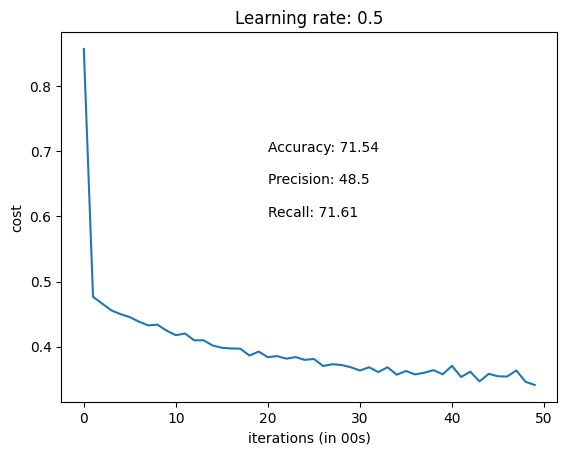

In [81]:
costs = np.squeeze(costs)
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (in 00s)')
plt.title("Learning rate: " + str(learning_rate))
plt.text(20, 0.7, "Accuracy: " + str(np.around(pred_test[1],2)) , fontsize = 10)
plt.text(20, 0.65, "Precision: " + str(np.around(pred_test[3],2)), fontsize = 10)
plt.text(20, 0.60, "Recall: " + str(np.around(pred_test[2],2)), fontsize = 10)
plt.show

The performance of the simple NN is very close to the model implemented using tensorflow. However, given the gap between train and dev/test results. It seems that the model has high variance and is over-fitting the training set. Adding regularization and dropout to the model might make it better. It is a very small dataset so it will likely over-fit the training set.

In [54]:
# lets see if increasing the layers makes the training set error/bias lower

layers_dims_extra = [45, 32, 16, 8, 4, 1]

parameters, costs = L_layer_model(sm_train_set_x, sm_train_set_y, layers_dims_extra, num_iterations = 5000, learning_rate = 0.5, print_cost = True)

Cost after iteration 0 : 0.8572924818863291
Cost after iteration 100 : 0.47659100157570944
Cost after iteration 200 : 0.46609928353897256
Cost after iteration 300 : 0.4557107007692631
Cost after iteration 400 : 0.44987292179345945
Cost after iteration 500 : 0.44537055880293525
Cost after iteration 600 : 0.43835540121111033
Cost after iteration 700 : 0.4326959244164279
Cost after iteration 800 : 0.4338103808173082
Cost after iteration 900 : 0.42459768784053226
Cost after iteration 1000 : 0.4176331166282963
Cost after iteration 1100 : 0.4202514168798555
Cost after iteration 1200 : 0.4097172241175017
Cost after iteration 1300 : 0.40989156950154865
Cost after iteration 1400 : 0.4018158635670034
Cost after iteration 1500 : 0.3983160806523625
Cost after iteration 1600 : 0.39724161715279527
Cost after iteration 1700 : 0.3969395515985822
Cost after iteration 1800 : 0.38643397233568455
Cost after iteration 1900 : 0.39242895999507477
Cost after iteration 2000 : 0.3838637729547984
Cost after iter

In [55]:
pred_train = predict(train_set_x, train_set_y, parameters)

Accuracy: 81.64714235001773
Precision: 60.95191840699369
Recall: 84.51178451178451


In [56]:
pred_test = predict(test_set_x, test_set_y, parameters)

Accuracy: 71.54009936124912
Precision: 48.500881834215164
Recall: 71.61458333333334


Making the network larger doesn't make much difference. It seems like the learning rate is also probably too high for later iterations so perhaps implementing learning decay may slighlty improve performance.